In [1]:
from environment.hydroenv import HydroEnv
from algorithms import DynamicProgramming, Qlearning
from algorithms.dqn import ReplayBuffer, DQN, DQNAgent
from algorithms.reinforce import ReinforceAgentDiscrete
from algorithms.reinforce import ReinforceAgentContinuous

import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
import gym
from gym import spaces

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import random
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

## Q learning

In [7]:
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

env = HydroEnv.Discret(
    t = 3,
    l_max = 100,
    l_min = 0,
    punition = -100
)

Q_model = Qlearning(
    env = env,
    gamma = 0.95,
    episodes = 300000,
    learning_rate = 1,
    learning_rate_decay = 1,
    epsilon = 1,
    epsilon_decay = 0.999945, #0.999945
    min_epsilon = 0.2
)

epsilon_history, reward_history_Q = Q_model.qlearning_solver()

ep: 0 %: 0.0 %
epsilon: 1
learning rate: 1 
ep: 10000 %: 3.3333333333333335 %
epsilon: 0.5769410837604694
learning rate: 1 
ep: 20000 %: 6.666666666666667 %
epsilon: 0.3328610141306998
learning rate: 1 
ep: 30000 %: 10.0 %
epsilon: 0.2
learning rate: 1 
ep: 40000 %: 13.333333333333334 %
epsilon: 0.2
learning rate: 1 
ep: 50000 %: 16.666666666666664 %
epsilon: 0.2
learning rate: 1 
ep: 60000 %: 20.0 %
epsilon: 0.2
learning rate: 1 
ep: 70000 %: 23.333333333333332 %
epsilon: 0.2
learning rate: 1 
ep: 80000 %: 26.666666666666668 %
epsilon: 0.2
learning rate: 1 
ep: 90000 %: 30.0 %
epsilon: 0.2
learning rate: 1 
ep: 100000 %: 33.33333333333333 %
epsilon: 0.2
learning rate: 1 
ep: 110000 %: 36.666666666666664 %
epsilon: 0.2
learning rate: 1 
ep: 120000 %: 40.0 %
epsilon: 0.2
learning rate: 1 
ep: 130000 %: 43.333333333333336 %
epsilon: 0.2
learning rate: 1 
ep: 140000 %: 46.666666666666664 %
epsilon: 0.2
learning rate: 1 
ep: 150000 %: 50.0 %
epsilon: 0.2
learning rate: 1 
ep: 160000 %: 53.

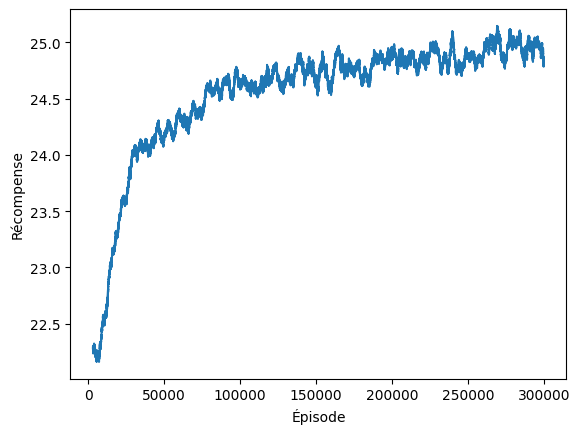

In [ ]:
window = 3000
data = np.array(reward_history_Q)
moving_avg = np.convolve(data, np.ones(window)/window, mode='valid')
xticks_Q = [ep for ep in range(Q_model.episodes)]

plt.plot(xticks_Q[window-1:], moving_avg)
plt.ticklabel_format(style = 'plain')
plt.xlabel('Épisode')
plt.ylabel('Récompense')
# plt.savefig('/Users/oli.dmrs/Library/CloudStorage/OneDrive-HECMontréal/StageHEC2025/images_graph/q-learning_v2.png')
plt.show()

In [ ]:
# def simulation(n : int) -> np.ndarray:
#     results = np.zeros(n)
#     count_non_visted = 0
#     for n in range(n):
#         pi, waterlevel, inflows = Q_model.extract_policy(40)
#         output = Q_model.extract_reward_of_pi(waterlevel, pi)
#         count_non_visted += Q_model.compute_non_visited_count(waterlevel, inflows, pi)
#         results[n] = output
#     return results, count_non_visted

# results, non_visited = simulation(5000) 
# print(non_visited)
# print(np.mean(results))
# print(np.std(results))

6
17.806536879185785
1.6434852872884864


## DQN

In [8]:
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

episodes = 500000

batch_size = 32
update_target = 300

# Definition of the environment
env = HydroEnv.Discret(
    t = 3,
    l_max = 100,
    l_min = 0,
    punition = -50
)

# Definition of the DQN agent
dqn_agent = DQNAgent(
    input_dim = env.observation_space.shape[0],
    output_dim = env.action_space.n * 2,
    nb_hidden = 2,
    hidden_size = 100,
    replay_buffer = ReplayBuffer(5000),
    learning_rate = 0.001,
    env = env,
    gamma = 0.9,
    init_eps = 1,
    final_eps = 0.1,
    eps_decay_rate = 0.9999969,
    learning_decay_rate = 1,
    final_learning_rate = 0.000005
)

# 0.99999975
# reward_history = []
# truncated_history = []
# epsilon_history_DQN = []
# count_truncated = 0
# for episode in range(episodes):
#     # Reset environment which implies randomly generating a state
#     env.reset()
#     episode_reward = 0
#     epsilon_history_DQN.append(dqn_agent.eps)
#     dqn_agent.epsilon_decay()
#     if episode % update_target == 0:
#         dqn_agent.update_target_network()
    
#     for t in range(env.t):
#         state = env.state
#         action, truncated_from_action = dqn_agent.choose_action(state)
        
#         next_state, reward, done, truncated, info = env.step(action)

#         dqn_agent.replay_buffer.add(state, action, reward, next_state, done)
#         dqn_agent.update(batch_size)
#         episode_reward += reward

#         if done or truncated:
#             if truncated:
#                 count_truncated += 1
#                 truncated_history.append(episode)
#             break
    
#     reward_history.append(episode_reward)
#     dqn_agent.alpha_decay()
#     if episode % 10000 == 0:
#         print(f'Episode: {episode}, % of episodes: {episode/episodes * 100} %')
#         print(f'epsilon: {round(dqn_agent.eps, 2)}')
#         print(f'alpha: {dqn_agent.learning_rate}')

# print(f'\n\n % of decisions which were eploration: {dqn_agent.exploration_episodes/(dqn_agent.exploration_episodes + dqn_agent.exploitation_episodes) * 100} %')
# print(f'% of truncated decisions: {count_truncated/(dqn_agent.exploration_episodes + dqn_agent.exploitation_episodes) * 100} %')
# dqn_agent.exploitation_episodes = 0
# dqn_agent.exploration_episodes = 0

In [9]:
# Load model weights from file
dqn_agent.dqn.load_state_dict(torch.load("/Users/oli.dmrs/Library/CloudStorage/OneDrive-HECMontréal/StageHEC2025/models/final_dqn_model.pth"))
print("Model loaded from dqn_model.pth")


Model loaded from dqn_model.pth


/var/folders/31/tgbtq8w94_q5gd2k_bswhf800000gn/T/ipykernel_97994/226766543.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dqn_agent.dqn.load_state_dict(torch.load("/Use

In [ ]:
# # Save the model weights to a file
# torch.save(dqn_agent.dqn.state_dict(), "/Users/oli.dmrs/Library/CloudStorage/OneDrive-HECMontréal/StageHEC2025/models/final_dqn_model.pth")
# print("Model saved to dqn_model.pth")


Model saved to dqn_model.pth


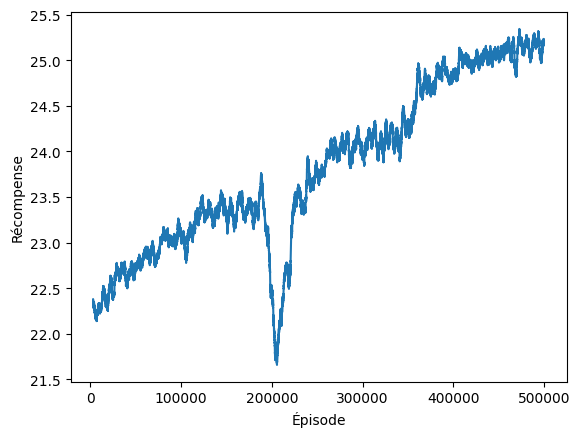

In [ ]:
window = 3000
def set_window(rewards):
    data = np.array(rewards)
    moving_avg = np.convolve(data, np.ones(window)/window, mode='valid')
    return moving_avg
xticks = [ep for ep in range(episodes)]
plt.plot(xticks[window-1:], set_window(list_reward[0])) #new
plt.xlabel('Épisode')
plt.ylabel('Récompense')
plt.savefig('/Users/oli.dmrs/Library/CloudStorage/OneDrive-HECMontréal/StageHEC2025/images_graph/DQN_new_rewards')
plt.show()

In [ ]:
def simulation(n : int):
    dqn_cumulative = np.zeros(n)
    qlearning_cumulative = np.zeros(n)
    nb_qlearning_nonvisited = 0
    for episode in range(n):
        dqn_reward = 0
        qlearning_reward = 0
        env.reset()
        waterlevel_dqn = 40
        waterlevel_q = 40
        for t in range(env.t):
            i = env.get_inflow(t)
            dqn_action = dqn_agent.dqn.act(dqn_agent.dqn.forward(torch.tensor([waterlevel_dqn, i, t], dtype=torch.float32)))
            waterlevel_dqn = waterlevel_dqn + i - dqn_action
            dqn_reward += env.get_current_reward(t, waterlevel_dqn, dqn_action)[0]

            q_action = np.argmax(Q_model.Q_table[t, waterlevel_q, i, :])
            if Q_model.visit_counts[t, waterlevel_q, i, q_action] == 0.0:
                nb_qlearning_nonvisited += 1
            waterlevel_q = waterlevel_q + i - q_action
            qlearning_reward += env.get_current_reward(t, waterlevel_q, q_action)[0]
            
        dqn_cumulative[episode] = dqn_reward
        qlearning_cumulative[episode] = qlearning_reward
    return dqn_cumulative, qlearning_cumulative, nb_qlearning_nonvisited

dqn_cumulative, qlearning_cumulative, nb_qlearning_nonvisited = simulation(5000) 

In [ ]:
print(dqn_cumulative)
print(qlearning_cumulative)
print(nb_qlearning_nonvisited)

print(dqn_cumulative.mean())
print(qlearning_cumulative.mean())
print('')
print(dqn_cumulative.std())
print(qlearning_cumulative.std())

[17.68309671 18.7254146  17.95037499 ... 18.22530799 18.83077512
 17.61657519]
[13.81342839 17.55780944 17.96434899 ... 16.80713842 17.63114072
 17.02903963]
1
13.707885030868004
17.040970360128995

21.912860601431987
1.4227789757612979


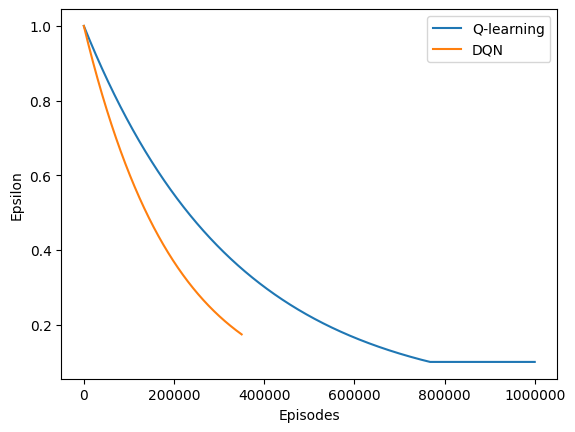

In [ ]:
xticks = [ep for ep in range(1000000)]
# plt.xticks(xticks)

plt.plot(xticks, epsilon_history, label = 'Q-learning')
  
plt.ticklabel_format(style = 'plain')
plt.plot(epsilon_history_DQN, label = 'DQN')
plt.legend()
plt.xlabel('Episodes')
plt.ylabel('Epsilon')
plt.savefig('images/epsilon-comparaison.png')
plt.show()

## REINFORCE

##### Discrete

In [4]:
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

episodes_reinforce = 150000
batch_size = 32

env = HydroEnv.Discret(
    t = 3,
    l_max = 100,
    l_min = 0,
    punition = -50
)

reinforce_discrete = ReinforceAgentDiscrete(
    input_dim = env.observation_space.shape[0],
    output_dim = env.action_space.n * 2,
    nb_hidden = 2,
    hidden_size = 100,
    gamma = 0.9,
    env = env,
    learning_rate = 0.00008, 
    learning_decay_rate = 1,
    final_learning_rate = 0.0001,
    beta = 0.4,
    beta_decay_rate = 0.99995
)
discounted_rewards_batch = []
reward_history_reinforce_d = []
states_batch = []
actions_batch = []

for episode in range(episodes_reinforce):
    # print(episode)
    if episode % 1000 == 0: 
        print(f'Episode: {episode}, % of episodes: {episode/episodes_reinforce * 100} %')
        print(f'learning rate: {reinforce_discrete.learning_rate:.10f}')
        print(f'beta: {reinforce_discrete.beta:.10f}')
    
    actions, states, rewards = reinforce_discrete.gather_an_episode()
    discounted_rewards = reinforce_discrete.discount_rewards(rewards)
    discounted_rewards_batch.append(discounted_rewards)
    states_batch.append(states)
    actions_batch.append(actions)

    if len(discounted_rewards_batch) == batch_size:
        reinforce_discrete.update(states_batch, actions_batch, discounted_rewards_batch)
        discounted_rewards_batch = []
        states_batch = []
        actions_batch = []

    reward_history_reinforce_d.append(sum(rewards))
    # reinforce.alpha_decay()
    reinforce_discrete.beta_decay()

Episode: 0, % of episodes: 0.0 %
learning rate: 0.0000800000
beta: 0.4000000000
Episode: 1000, % of episodes: 0.6666666666666667 %
learning rate: 0.0000800000
beta: 0.3804912942
Episode: 2000, % of episodes: 1.3333333333333335 %
learning rate: 0.0000800000
beta: 0.3619340623
Episode: 3000, % of episodes: 2.0 %
learning rate: 0.0000800000
beta: 0.3442818995
Episode: 4000, % of episodes: 2.666666666666667 %
learning rate: 0.0000800000
beta: 0.3274906637
Episode: 5000, % of episodes: 3.3333333333333335 %
learning rate: 0.0000800000
beta: 0.3115183662
Episode: 6000, % of episodes: 4.0 %
learning rate: 0.0000800000
beta: 0.2963250658
Episode: 7000, % of episodes: 4.666666666666667 %
learning rate: 0.0000800000
beta: 0.2818727694
Episode: 8000, % of episodes: 5.333333333333334 %
learning rate: 0.0000800000
beta: 0.2681253371
Episode: 9000, % of episodes: 6.0 %
learning rate: 0.0000800000
beta: 0.2550483912
Episode: 10000, % of episodes: 6.666666666666667 %
learning rate: 0.0000800000
beta: 0

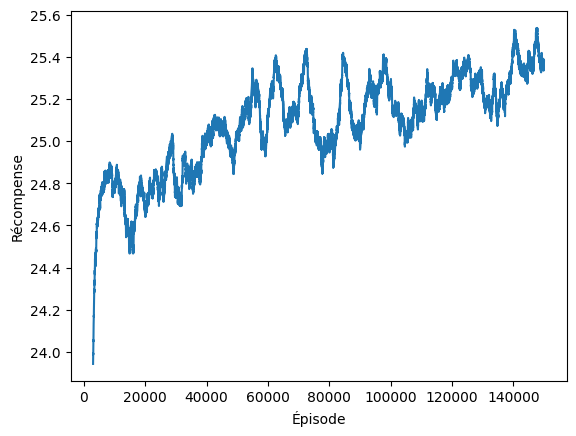

In [6]:
window = 3000
data = np.array(reward_history_reinforce_d)
moving_avg = np.convolve(data, np.ones(window)/window, mode='valid')
xticks_Q = [ep for ep in range(episodes_reinforce)]

plt.plot(xticks_Q[window-1:], moving_avg)
plt.ticklabel_format(style = 'plain')
plt.xlabel('Épisode')
plt.ylabel('Récompense')
# plt.savefig('/Users/oli.dmrs/Library/CloudStorage/OneDrive-HECMontréal/StageHEC2025/images_graph/REINFORCE.png')
plt.show()

#### Continuous

In [3]:
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

episodes_reinforce = 100000
batch_size = 32

env = HydroEnv.Continuous(
    t = 3,
    l_max = 100.0,
    l_min = 0.0,
    punition = -50
)

reinforce_continuous = ReinforceAgentContinuous(
    input_dim = len(env.observation_space),
    output_dim = 2,
    nb_hidden = 2,
    hidden_size = 100,
    gamma = 0.9,
    env = env,
    learning_rate = 0.0000055, 
)
discounted_rewards_batch = []
reward_history_reinforce_c = []
states_batch = []
actions_batch = []

for episode in range(episodes_reinforce):
    # print(episode)
    if episode % 1000 == 0: 
        print(f'Episode: {episode}, % of episodes: {episode/episodes_reinforce * 100} %')
        print(f'learning rate: {reinforce_continuous.learning_rate:.10f}')
    
    actions, states, rewards = reinforce_continuous.gather_an_episode()
    discounted_rewards = reinforce_continuous.discount_rewards(rewards)
    discounted_rewards_batch.append(discounted_rewards)
    states_batch.append(states)
    actions_batch.append(actions)

    if len(discounted_rewards_batch) == batch_size:
        reinforce_continuous.update(states_batch, actions_batch, discounted_rewards_batch)
        discounted_rewards_batch = []
        states_batch = []
        actions_batch = []

    reward_history_reinforce_c.append(sum(rewards))

Episode: 0, % of episodes: 0.0 %
learning rate: 0.0000055000
Episode: 1000, % of episodes: 1.0 %
learning rate: 0.0000055000
Episode: 2000, % of episodes: 2.0 %
learning rate: 0.0000055000
Episode: 3000, % of episodes: 3.0 %
learning rate: 0.0000055000
Episode: 4000, % of episodes: 4.0 %
learning rate: 0.0000055000
Episode: 5000, % of episodes: 5.0 %
learning rate: 0.0000055000
Episode: 6000, % of episodes: 6.0 %
learning rate: 0.0000055000
Episode: 7000, % of episodes: 7.000000000000001 %
learning rate: 0.0000055000
Episode: 8000, % of episodes: 8.0 %
learning rate: 0.0000055000
Episode: 9000, % of episodes: 9.0 %
learning rate: 0.0000055000
Episode: 10000, % of episodes: 10.0 %
learning rate: 0.0000055000
Episode: 11000, % of episodes: 11.0 %
learning rate: 0.0000055000
Episode: 12000, % of episodes: 12.0 %
learning rate: 0.0000055000
Episode: 13000, % of episodes: 13.0 %
learning rate: 0.0000055000
Episode: 14000, % of episodes: 14.000000000000002 %
learning rate: 0.0000055000
Episo

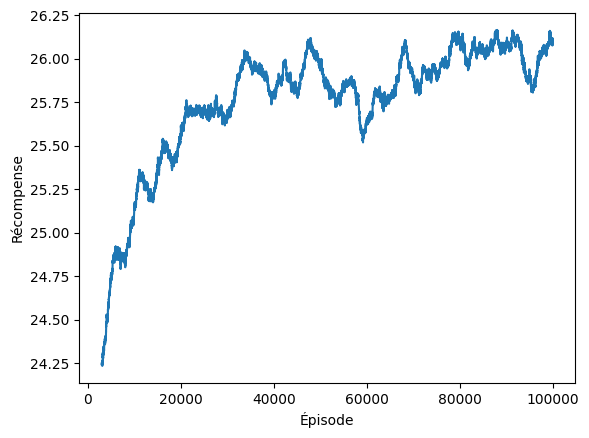

In [15]:
window = 3000
data = np.array(reward_history_reinforce_c)
moving_avg = np.convolve(data, np.ones(window)/window, mode='valid')
xticks_Q = [ep for ep in range(episodes_reinforce)]
'a'
plt.plot(xticks_Q[window-1:], moving_avg)
plt.ticklabel_format(style = 'plain')
plt.xlabel('Épisode')
plt.ylabel('Récompense') 
# plt.savefig('/Users/oli.dmrs/Library/CloudStorage/OneDrive-HECMontréal/StageHEC2025/images_graph/REINFORCE.png')
plt.show()

## Comparison

### Dynamic Programming

In [40]:
np.random.seed(1)
i0 = int(max(10 + 5 * np.random.normal(loc = 0, scale = 1), 0))
i1 = int(max(i0 + 5 * np.random.normal(loc = 0, scale = 1), 0))
i2 = int(max(2 * i1 + 5 * np.random.normal(loc = 0, scale = 1), 0))

env = HydroEnv(
    t = 3,
    l_max = 100,
    l_min = 0,
    punition = -100,
    deterministic_inflows = [i0, i1, i2]
)

dp = DynamicProgramming(
    env
)
v, pi = dp.dynamic_prog_solution2()

print(f'Waterinflows: {i0, i1, i2}')
pi_t0, waterlevels_t0, reward = dp.policy_extraction(pi, 40)
print(f'Actions taken starting at l0 = 40: {pi_t0}')
print(f'Waterlevels for each timestep: {waterlevels_t0}')
print(f'Reward: {reward}')

Waterinflows: (18, 14, 25)
Actions taken starting at l0 = 40: [11, 15, 23]
Waterlevels for each timestep: [40, 47, 46, 48]
Reward: 27.65411047791924


In [42]:
# QLEARNING QLEARNING QLEARNING QLEARNING

np.random.seed(1)
i0 = int(max(10 + 5 * np.random.normal(loc = 0, scale = 1), 0))
i1 = int(max(i0 + 5 * np.random.normal(loc = 0, scale = 1), 0))
i2 = int(max(2 * i1 + 5 * np.random.normal(loc = 0, scale = 1), 0))

pi_Q, waterlevel_Q, inflow_Q, reward = Q_model.extract_policy(40, [i0, i1, i2, 0])

print(f'Waterinflows: {inflow_Q}')
print(f'Actions taken starting at l0 = 40: {pi_Q}')
print(f'Waterlevels for each timestep: {waterlevel_Q}')
print(f'Reward: {reward}')

Waterinflows: [18, 14, 25, 0]
Actions taken starting at l0 = 40: [1, 22, 32]
Waterlevels for each timestep: [40, 57, 49, 42]
Reward: 26.53358727202157


In [45]:
#DQN DQN DQN DQN DQN

np.random.seed(1)
i0 = int(max(10 + 5 * np.random.normal(loc = 0, scale = 1), 0))
i1 = int(max(i0 + 5 * np.random.normal(loc = 0, scale = 1), 0))
i2 = int(max(2 * i1 + 5 * np.random.normal(loc = 0, scale = 1), 0))
inflows = [i0, i1, i2, 0]
l = 40
waterlevel_dqn = [l]
dqn_actions = []
dqn_reward = 0
for t in range(env.t + 1):
    actions = dqn_agent.dqn.forward(torch.tensor([l, inflows[t], t], dtype=torch.float32))
    min_valid_action_space = max(0, l + inflows[t] - env.l_max)
    max_valid_action_space = min(l + inflows[t], env.l_max) + 1
    dqn_action = dqn_agent.dqn.act(actions, min_valid_action_space, max_valid_action_space)
    dqn_reward += env.get_current_reward(t, l, dqn_action)[0]
    l = l + inflows[t] - dqn_action
    if t != env.t:
        waterlevel_dqn.append(l)
        dqn_actions.append(dqn_action)
    

print(f'Waterinflows: {inflows}')
print(f'Actions taken starting at l0 = 40: {dqn_actions}')
print(f'Waterlevels for each timestep: {waterlevel_dqn}')
print(f'Reward: {dqn_reward}')

Waterinflows: [18, 14, 25, 0]
Actions taken starting at l0 = 40: [14, 18, 20]
Waterlevels for each timestep: [40, 44, 40, 45]
Reward: 27.588101034149197


In [ ]:
#REINFORCE REINFORCE REINFORCE


np.random.seed(1)
i0 = int(max(10 + 5 * np.random.normal(loc = 0, scale = 1), 0))
i1 = int(max(i0 + 5 * np.random.normal(loc = 0, scale = 1), 0))
i2 = int(max(2 * i1 + 5 * np.random.normal(loc = 0, scale = 1), 0))
inflows = [i0, i1, i2, 0]
l = 40
waterlevel_reinforce = [l]
reinforce_actions = []
reinforce_reward = 0
for t in range(env.t + 1):
    actions = reinforce_discrete.policynetwork.forward(torch.tensor([l, inflows[t], t], dtype=torch.float32))
    min_valid_action_space = max(0, l + inflows[t] - env.l_max)
    max_valid_action_space = min(l + inflows[t], env.l_max) + 1
    reinforce_action = reinforce_discrete.policynetwork.act(actions, min_valid_action_space, max_valid_action_space)
    reinforce_reward += env.get_current_reward(t, l, reinforce_action)[0]
    l = l + inflows[t] - reinforce_action
    if t != env.t:
        waterlevel_reinforce.append(l)
        reinforce_actions.append(reinforce_action)
    

print(f'Waterinflows: {inflows}')
print(f'Actions taken starting at l0 = 40: {reinforce_actions}')
print(f'Waterlevels for each timestep: {waterlevel_reinforce}')
print(f'Reward: {reinforce_reward}')

Waterinflows: [18, 14, 25, 0]
Actions taken starting at l0 = 40: [19, 19, 19]
Waterlevels for each timestep: [40, 39, 34, 40]
Reward: 27.372140536378247


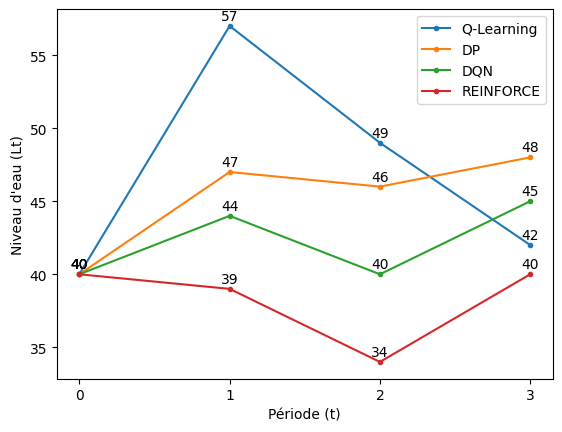

In [48]:
x = [0,1,2,3]

plt.plot(x, waterlevel_Q, marker = '.', label = 'Q-Learning')
plt.plot(x, waterlevels_t0, marker = '.', label = 'DP')
plt.plot(x, waterlevel_dqn, marker = '.', label = 'DQN')
plt.plot(x, waterlevel_reinforce, marker = '.', label = 'REINFORCE')
for i, txt in enumerate(waterlevel_Q):
    plt.text(x[i], waterlevel_Q[i] + 0.2, str(txt), ha='center', va='bottom')
for i, txt in enumerate(waterlevels_t0):
    plt.text(x[i], waterlevels_t0[i] + 0.2, str(txt), ha='center', va='bottom')
for i, txt in enumerate(waterlevel_dqn):
    plt.text(x[i], waterlevel_dqn[i] + 0.2, str(txt), ha='center', va='bottom')
for i, txt in enumerate(waterlevel_reinforce):
    plt.text(x[i], waterlevel_reinforce[i] + 0.2, str(txt), ha='center', va='bottom')
locator = ticker.MultipleLocator(1)
plt.gca().xaxis.set_major_locator(locator)
plt.xlabel('Période (t)')
plt.ylabel("Niveau d'eau (Lt)")
plt.legend()
plt.savefig('/Users/oli.dmrs/Library/CloudStorage/OneDrive-HECMontréal/StageHEC2025/images_graph/AlgoComparison.png')
plt.show()

In [10]:
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

def simulation(n : int):
    dp_cumulative = np.zeros(n)
    qlearning_cumulative = np.zeros(n)
    dqn_cumulative = np.zeros(n)
    reinforce_cumulative_d = np.zeros(n)
    nb_qlearning_nonvisited = 0
    reinforce_cumulative_c = np.zeros(n)
    for episode in range(n):
        waterlevel_t0 = random.randint(0,99)

        if episode % 1000 == 0:
            print(episode)

        qlearning_reward = 0
        dqn_reward = 0
        reinforce_reward_d = 0
        reinforce_reward_c = 0

        env.reset()

        waterlevel_q = waterlevel_t0
        waterlevel_dqn = waterlevel_t0
        waterlevel_reinforce_d = waterlevel_t0
        waterlevel_reinforce_c = waterlevel_t0

        i0 = int(max(10 + 5 * np.random.normal(loc = 0, scale = 1), 0))
        i1 = int(max(i0 + 5 * np.random.normal(loc = 0, scale = 1), 0))
        i2 = int(max(2 * i1 + 5 * np.random.normal(loc = 0, scale = 1), 0))
        inflows = [i0, i1, i2, 0]
        dp_env = HydroEnv.Discret(
            t = 3,
            l_max = 100,
            l_min = 0,
            punition = -100,
            deterministic_inflows = inflows
        )

        # DP
        dp = DynamicProgramming(dp_env)
        v, pi = dp.dynamic_prog_solution2()
        pi_t0, waterlevels_t0, reward = dp.policy_extraction(pi, waterlevel_t0)
        dp_cumulative[episode] = reward
        
        for t in range(env.t + 1):
            # DQN
            q_values_dqn = dqn_agent.dqn.forward(torch.tensor([waterlevel_dqn, inflows[t], t], dtype=torch.float32))
            min_valid_action_space = int(max(0, waterlevel_dqn + inflows[t] - env.l_max))
            max_valid_action_space = int(min(waterlevel_dqn + inflows[t], env.l_max))
            dqn_action = dqn_agent.dqn.act(q_values_dqn, min_valid_action_space, max_valid_action_space + 1)
            dqn_reward += env.get_current_reward(t, waterlevel_dqn, dqn_action)[0]
            waterlevel_dqn = waterlevel_dqn + inflows[t] - dqn_action
            
            # Reinforce Discrete
            reinforce_actions_d = reinforce_discrete.policynetwork.forward(torch.tensor([waterlevel_reinforce_d, inflows[t], t], dtype=torch.float32))
            min_valid_action_space = int(max(0, waterlevel_reinforce_d + inflows[t] - env.l_max))
            max_valid_action_space = int(min(waterlevel_reinforce_d + inflows[t], env.l_max))
            reinforce_action_d = reinforce_discrete.policynetwork.act(reinforce_actions_d, min_valid_action_space, max_valid_action_space + 1)
            reinforce_reward_d += env.get_current_reward(t, waterlevel_reinforce_d, reinforce_action_d)[0]
            waterlevel_reinforce_d = waterlevel_reinforce_d + inflows[t] - reinforce_action_d
            
            # Reinforce Continuous
            reinforce_actions_c = reinforce_continuous.policynetwork.forward(torch.tensor([waterlevel_reinforce_c, inflows[t], t], dtype=torch.float32))
            min_valid_action_space = max(0, waterlevel_reinforce_c + inflows[t] - env.l_max)
            max_valid_action_space = min(waterlevel_reinforce_c + inflows[t], env.l_max)
            reinforce_action_c = reinforce_continuous.policynetwork.act(reinforce_actions_c, min_valid_action_space, max_valid_action_space)
            reinforce_reward_c += env.get_current_reward(t, waterlevel_reinforce_c, reinforce_action_c)[0]
            waterlevel_reinforce_c = waterlevel_reinforce_c + inflows[t] - reinforce_action_c
            print(t)
            print(min_valid_action_space, max_valid_action_space)
            print(f'Action: {reinforce_action_c}')
            print(f'waterlevel: {waterlevel_reinforce_c}')
            print(f'Inflows: {inflows}')
            print(f'Reward: {reinforce_reward_c}')
        # if reinforce_reward_c < 0:
        #     print('discrete')
        #     print(f'Action: {reinforce_action_d}')
        #     print(f'waterlevel: {waterlevel_reinforce_d}')
            
        #     print('continuous')
        #     print(f'Action: {reinforce_action_c}')
        #     print(f'waterlevel: {waterlevel_reinforce_c}')
        #     print(f'Inflows: {inflows}')
            
        #Q learning
        for t in range(env.t + 1):
            if t != env.t:
                min_valid_action_space = int(max(0, waterlevel_q + inflows[t] - env.l_max))
                max_valid_action_space = int(min(waterlevel_q + inflows[t], env.l_max) + 1)
                q_action = np.argmax(Q_model.Q_table[t, waterlevel_q, inflows[t], min_valid_action_space : max_valid_action_space]) + min_valid_action_space
                qlearning_reward += env.get_current_reward(t, waterlevel_q, q_action)[0]
                waterlevel_q = waterlevel_q + inflows[t] - q_action
            else:
                qlearning_reward += env.get_current_reward(t, waterlevel_q, 0)[0]

        qlearning_cumulative[episode] = qlearning_reward
        dqn_cumulative[episode] = dqn_reward
        reinforce_cumulative_d[episode] = reinforce_reward_d
        reinforce_cumulative_c[episode] = reinforce_reward_c

    return dp_cumulative, qlearning_cumulative, dqn_cumulative, reinforce_cumulative_d, reinforce_cumulative_c, nb_qlearning_nonvisited,

dp_cumulative, qlearning_cumulative, dqn_cumulative, reinforce_cumulative_d, reinforce_cumulative_c ,nb_qlearning_nonvisited = simulation(1000) 


0
Sigmoid_action: 0.40194499492645264
0
0 19
Action: 7.6369549036026
waterlevel: 11.3630450963974
Inflows: [2, 9, 12, 0]
Reward: 5.04642183687729
Sigmoid_action: 0.4903440475463867
1
0 20.3630450963974
Action: 9.984897952937104
waterlevel: 10.378147143460296
Inflows: [2, 9, 12, 0]
Reward: 9.957655041705877
Sigmoid_action: 0.5002680420875549
2
0 22.378147143460296
Action: 11.195071857006093
waterlevel: 11.183075286454203
Inflows: [2, 9, 12, 0]
Reward: 14.890381564212765
Sigmoid_action: 0.3844032287597656
3
0 11.183075286454203
Action: 4.298810247576537
waterlevel: 6.8842650388776665
Inflows: [2, 9, 12, 0]
Reward: 19.890476998182717
Sigmoid_action: 0.21473222970962524
0
0 87
Action: 18.681703984737396
waterlevel: 68.3182960152626
Inflows: [15, 9, 21, 0]
Reward: 7.270148913614584
Sigmoid_action: 0.1950940638780594
1
0 77.3182960152626
Action: 15.084340581744346
waterlevel: 62.23395543351826
Inflows: [15, 9, 21, 0]
Reward: 14.286703960729835
Sigmoid_action: 0.2874393165111542
2
0 83.233955

In [11]:
print(f'DP mean: {np.mean(dp_cumulative)}')
print(f'Q-learning mean: {np.mean(qlearning_cumulative)}')
print(f'DQN mean: {np.mean(dqn_cumulative)}')
print(f'REINFORCE discrete mean: {np.mean(reinforce_cumulative_d)}')
print(f'REINFORCE  continuous mean: {np.mean(reinforce_cumulative_c)}')
print('')
print(f'DP STD: {np.std(dp_cumulative)}')
print(f'Q-learning STD: {np.std(qlearning_cumulative)}')
print(f'DQN STD: {np.std(dqn_cumulative)}')
print(f'REINFORCE discrete STD: {np.std(reinforce_cumulative_d)}')
print(f'REINFORCE continuous STD: {np.std(reinforce_cumulative_c)}')
print('')
print(f'DP max: {np.max(dp_cumulative)}')
print(f'Q-learning max: {np.max(qlearning_cumulative)}')
print(f'DQN max: {np.max(dqn_cumulative)}')
print(f'REINFORCE discrete max: {np.max(reinforce_cumulative_d)}')
print(f'REINFORCE continuous max: {np.max(reinforce_cumulative_c)}')
print('')
print(f'DP min: {np.min(dp_cumulative)}')
print(f'Q-learning min: {np.min(qlearning_cumulative)}')
print(f'DQN min: {np.min(dqn_cumulative)}')
print(f'REINFORCE discrete min: {np.min(reinforce_cumulative_d)}')
print(f'REINFORCE continuous min: {np.min(reinforce_cumulative_c)}')


DP mean: 26.338106211263952
Q-learning mean: 25.774343159578233
DQN mean: 26.202996737225448
REINFORCE discrete mean: 25.120019437403368
REINFORCE  continuous mean: 25.892431653274045

DP STD: 4.567698826144216
Q-learning STD: 4.522001995686927
DQN STD: 4.629217407043459
REINFORCE discrete STD: 5.836533941502905
REINFORCE continuous STD: 4.843094871546055

DP max: 32.8734709568625
Q-learning max: 32.45686536081112
DQN max: 32.79785024425418
REINFORCE discrete max: 32.76934818606156
REINFORCE continuous max: 32.80773046239652

DP min: 6.1092475827643655
Q-learning min: 6.1092475827643655
DQN min: 4.564348191467836
REINFORCE discrete min: 3.7376696182833684
REINFORCE continuous min: 5.444932493623902
